In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

manu_sales = web.DataReader('MNFCTRSMNSA', 'fred', '1992', '2022').squeeze()
manu_sales

DATE
1992-01-01    209438
1992-02-01    232679
1992-03-01    249673
1992-04-01    239666
1992-05-01    243231
               ...  
2021-09-01    530156
2021-10-01    529691
2021-11-01    515961
2021-12-01    528638
2022-01-01    495157
Name: MNFCTRSMNSA, Length: 361, dtype: int64

In [50]:
manu_sales.isnull().any()

False

In [51]:
from scipy.stats.stats import moment
from statsmodels.tsa.stattools import adfuller
import scipy.stats as sp
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import gaussian_kde, norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import math

def show_stats(currency):
    var = np.var(currency)
    mean = np.mean(currency)
    skew = sp.skew(currency)
    kurtosis = sp.kurtosis(currency)
    string = f" Mean: {mean:.4f}\n Var: {var:.4f}\n Skew: {skew:.4f} \n Kurt: {kurtosis:.4f} \n ADF(p-val): {adfuller(currency)[1]:.4f}"
    return string

def plot_data(curr_list, curr_names, title_name):
    title_name = str(title_name)
    num_of_currencies = len(curr_list)
    sns.set_style('dark')
    fig, axs = plt.subplots(num_of_currencies, sharex=True, figsize=(12, 12))
    fig.suptitle(title_name)
    for i, name in enumerate(curr_names):
        axs[i].set_title(name)
    for i, obj in enumerate(curr_list):
        axs[i].plot(obj, c='m')
        axs[i].text(x=0.83, y=0.6, s=show_stats(obj),transform=axs[i].transAxes, c='lime')

def plot_correlation(currency,title_name, lags=None):
    lags = min(10, int(len(currency)/5)) if lags is None else lags
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(2,2, figsize=(12, 12))
    fig.suptitle(title_name)

    axs[0][0].hist(currency, density=True, label="Hist")
    axs[0][0].set_title("Histogram")

    qqplot(currency, line="s", ax=axs[0][1])
    axs[0][1].set_title("Normal Q-Q")

    plot_acf(x=currency, lags=lags, zero=False, ax=axs[1][0])
    axs[1][0].set_title("ACF")


    plot_pacf(x=currency, lags=lags, zero=False, ax=axs[1][1])
    axs[1][1].set_title("PACF")


    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    plt.show()


In [52]:
len(manu_sales)

361

In [53]:
(len(manu_sales)-12)

349

In [54]:
int((len(manu_sales)-12)*.8)

279

In [55]:
manu_sales.index[279]

Timestamp('2015-04-01 00:00:00')

In [56]:
train_end = 279
test_end = 349

train_idx = manu_sales.index[:train_end]
val_idx = manu_sales.index[train_end:test_end]
test_idx = manu_sales.index[test_end:]


train = manu_sales[train_idx]
val = manu_sales[val_idx]
test = manu_sales[test_idx]

print(train_idx)

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01'],
              dtype='datetime64[ns]', name='DATE', length=279, freq=None)


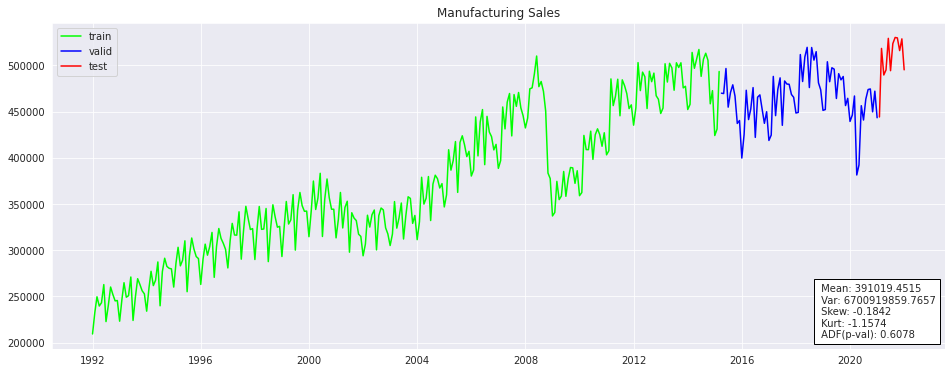

In [57]:



def plot_data(train=None, valid=None, test=None, full=None,title=str, mode = "full"):
    sns.set_style('darkgrid')
    plt.figure(figsize=(16,6))
    plt.title(title)
    if mode == "full":
        plt.plot(full, c='lime')
        a = AnchoredText(s=show_stats(full), loc=4, borderpad=0.5)
    elif mode == "train":
        plt.plot(train, c='lime')
        a = AnchoredText(s=show_stats(train), loc=4, borderpad=0.5)
    elif mode == "mult":
        plt.plot(train, c='lime')
        plt.plot(valid, c='blue')
        plt.plot(test, c='red')
        plt.legend(['train', 'valid', 'test'])
        a = AnchoredText(s=show_stats(full), loc=4, borderpad=0.5)
    plt.gca().add_artist(a)
    plt.show()

plot_data(train=train, valid=val, test=test, full=manu_sales,title="Manufacturing Sales", mode="mult")

In [58]:
log_train = np.log(train)
diff_train = log_train.diff(12).dropna()

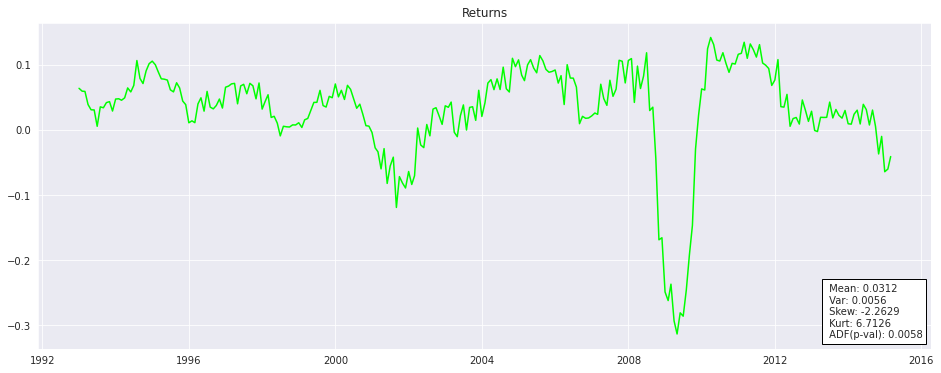

In [59]:
plot_data(train=diff_train, title="Returns", mode="train")

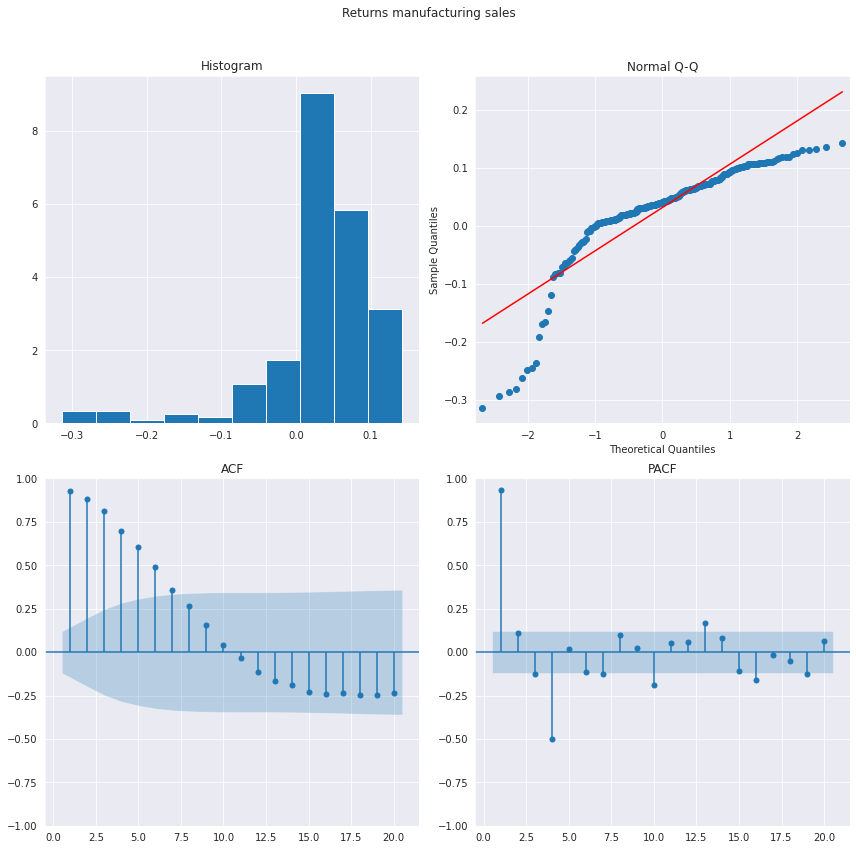

In [60]:
plot_correlation(diff_train,title_name="Returns manufacturing sales",lags=20)

In [61]:
warnings.filterwarnings('ignore')
model = SARIMAX(endog=train,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 12),).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        MNFCTRSMNSA   No. Observations:                  279
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2983.403
Date:                            Fri, 13 May 2022   AIC                           5976.806
Time:                                    04:08:38   BIC                           5994.962
Sample:                                01-01-1992   HQIC                          5984.090
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.006    160.177      0.000       0.977       1.002
ma.L1         -0.2407      0.034     -7.003      0.000      -0.308      -0.173
ar.S.L12       0.9986      0.001    912.669      0.000       0.997       1.001
ma.S.L12      -0.7896      0.030    -26.234      0.000      -0.849      -0.731
sigma2        9.5e+07   1.15e-10   8.26e+17      0.000     9.5e+07     9.5e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               329.96
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               7.44   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+33. Standard errors may be unstable.
"""

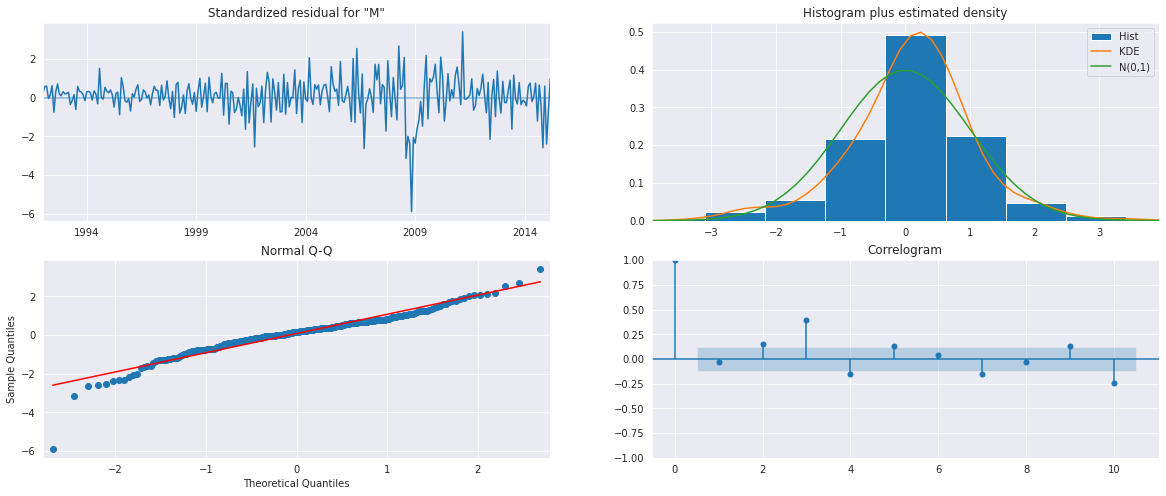

In [62]:
model.plot_diagnostics(figsize=(20,8))
plt.show()

In [63]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import math
rolling_forecasts = []
residuals = []

for i in range(len(val)):
    idx = val_idx[i]
    train = manu_sales[:idx]
    sarimax_model = SARIMAX(endog=train,
                            order=(1, 0, 1),
                            seasonal_order=(1, 0, 1, 12),
                            initialization='approximate_diffuse')
    model_fit = sarimax_model.fit(disp=0)
    pred = model_fit.forecast()
    rolling_forecasts.append(pred)
    y = val[i]
    yhat = pred[0]
    res = y - yhat
    residuals.append(res)
    print(f"Observed: {y} Predicted: {yhat:.4f} Residuals: {res:.4f}")

rolling_predictions = pd.Series(rolling_forecasts, index=val.index)


Observed: 469899 Predicted: 474706.2710 Residuals: -4807.2710
Observed: 469475 Predicted: 478790.1000 Residuals: -9315.1000
Observed: 496586 Predicted: 473090.7902 Residuals: 23495.2098
Observed: 454788 Predicted: 467034.9784 Residuals: -12246.9784
Observed: 470575 Predicted: 475407.5588 Residuals: -4832.5588
Observed: 478931 Predicted: 470812.6931 Residuals: 8118.3069
Observed: 466724 Predicted: 432422.3532 Residuals: 34301.6468
Observed: 437157 Predicted: 446921.8581 Residuals: -9764.8581
Observed: 440316 Predicted: 405699.3908 Residuals: 34616.6092
Observed: 399750 Predicted: 404350.9175 Residuals: -4600.9175
Observed: 425230 Predicted: 461799.9049 Residuals: -36569.9049
Observed: 473035 Predicted: 454290.7057 Residuals: 18744.2943
Observed: 441341 Predicted: 440820.3826 Residuals: 520.6174
Observed: 452785 Predicted: 470201.5201 Residuals: -17416.5201
Observed: 475935 Predicted: 445313.4006 Residuals: 30621.5994
Observed: 422080 Predicted: 435089.3981 Residuals: -13009.3981
Observe

In [64]:
rmse = np.sqrt(mean_squared_error(val, rolling_predictions))
print(f"Test RMSE: {rmse}")

Test RMSE: 20116.310823933167


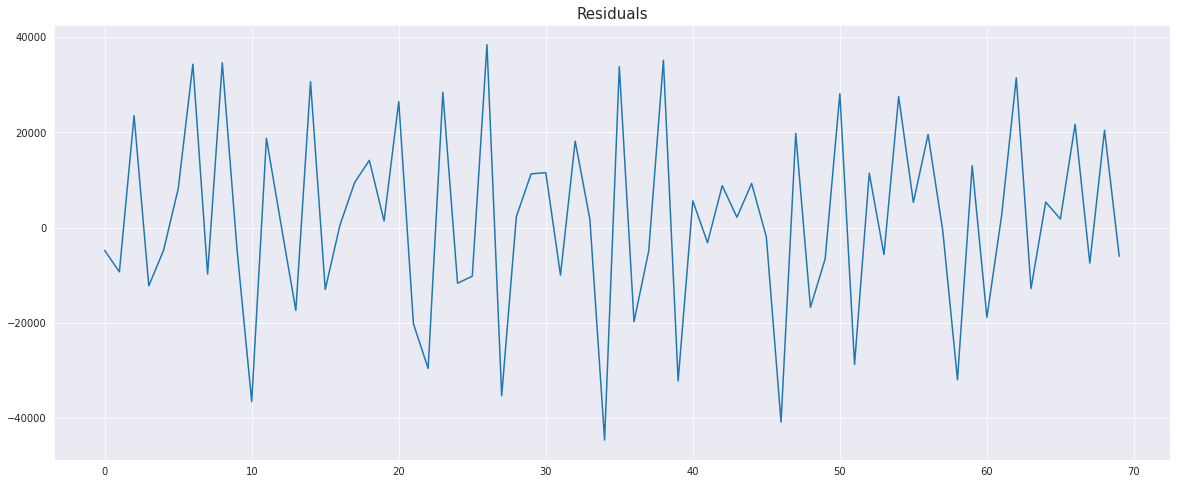

In [65]:
plt.figure(figsize=(20,8))
plt.title("Residuals",fontsize=15)
plt.plot(residuals)
plt.show()

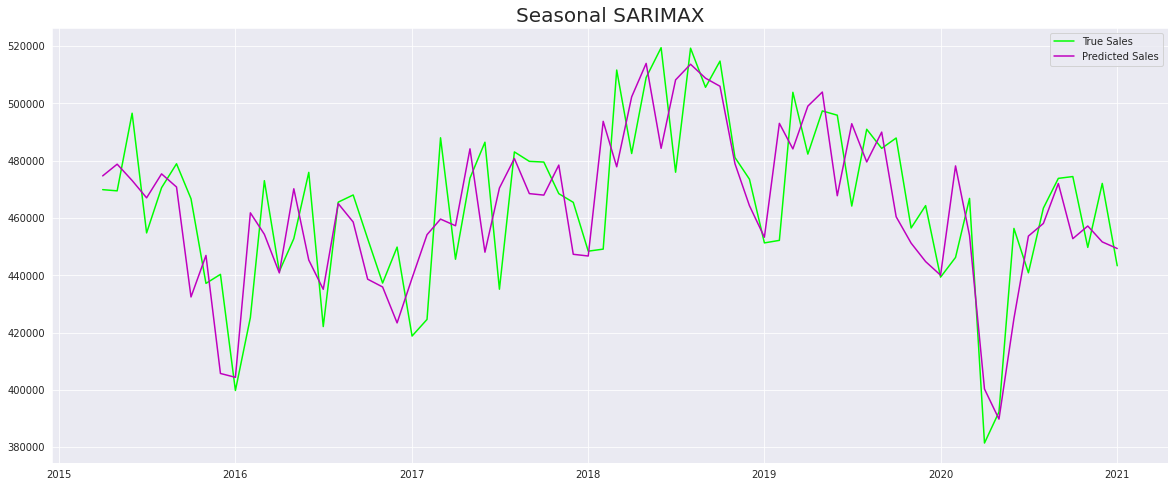

In [66]:
#summary of the model
plt.figure(figsize=(20,8))
plt.title("Seasonal SARIMAX", fontsize=20)
plt.plot(val, c='lime', label='True Sales')
plt.plot(rolling_predictions, c='m', label='Predicted Sales')
plt.legend()
plt.show()

In [67]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mean_squared_error(y_true, y_pred))
    return output

RMSE(val, rolling_predictions)

20116.310823933167

In [72]:
from itertools import product
from numpy.linalg import LinAlgError

l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

In [75]:
from tqdm import tqdm
results = {}

for p1, q1, p2, q2 in tqdm(params):
    rolling_forecasts = []
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
       continue
    convergence_error = stationarity_error = 0
    for i in range(len(val)):
        idx = val_idx[i]
        train = manu_sales[:idx]
        try:
            model = SARIMAX(endog=train,
                            order=(p1, 0, q1),
                            seasonal_order=(p2, 0, q2, 12),
                            initialization='approximate_diffuse')
            model_fit = model.fit(disp=0)

        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1


        pred = model_fit.forecast(horizon=1, reindex=False)
        rolling_forecasts.append(pred)

        aic.append(model_fit.aic)
        bic.append(model_fit.bic)

    rolling_predictions = pd.Series(rolling_forecasts, index=val.index)
    results[(p1, q1, p2, q2)] = [np.sqrt(mean_squared_error(val, rolling_predictions)),
                                 np.mean(aic),
                                 np.std(aic),
                                 np.mean(bic),
                                 np.std(bic),
                                 convergence_error,
                                 stationarity_error]

sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'AIC', 'AIC_std', 'BIC', 'BIC_std','convergence_error',
                           'stationarity_error']
#sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()


100%|██████████| 81/81 [3:41:50<00:00, 164.33s/it]  


AttributeError: 'DataFrame' object has no attribute 'RMSE_std'

In [77]:
sarimax_results.columns = ['RMSE', 'AIC', 'AIC_std', 'BIC', 'BIC_std','convergence_error',
                           'stationarity_error']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']


In [79]:
sarimax_results.sort_values(by='RMSE')

,,,,RMSE,AIC,AIC_std,BIC,BIC_std,convergence_error,stationarity_error
p1,q1,p2,q2,,,,,,,
2,3,0,0,13357.004744,51084.890737,468.399648,51107.384212,468.786063,0.0,0.0
3,3,0,0,13518.005857,51087.637021,467.121275,51113.879410,467.572113,0.0,0.0
1,2,0,0,13701.149761,51086.701905,468.169625,51101.697556,468.427236,0.0,0.0
2,1,0,0,13909.023099,51081.921018,467.947633,51096.916669,468.205240,0.0,0.0
3,1,0,0,13970.220450,51083.895920,467.931529,51102.640483,468.253538,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2,3,2,2,24703.057277,50894.590373,455.144672,50932.079499,455.788583,0.0,0.0
1,3,2,1,24716.849878,50901.850986,454.946767,50931.842287,455.461905,0.0,0.0
2,3,2,1,24746.205311,50892.596387,455.141199,50926.336601,455.720719,0.0,0.0


In [83]:
sarimax_results.to_csv('sarimax_results.csv')